In [181]:
import sys
sys.path.append('..')

In [182]:
%load_ext autoreload
%autoreload 2
from my_code import model as m
from my_code import layers
from my_code import functions as f

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

- generate random file

In [183]:
# import random

# scores_dict = dict(zip(f.POSSIBLE_AMINOACIDS, list(range(len(f.POSSIBLE_AMINOACIDS)))))

# # Generate the file
# with open('../data/mock_file.txt', 'w') as file:
#     for _ in range(10000):  # Change the number to generate more or fewer lines
#         string = ''.join(random.choice(f.POSSIBLE_AMINOACIDS) for _ in range(12))
#         score = (sum([scores_dict[amino] for amino in string])/110 - 1)*100 # create a score
#         file.write(f'{string}  {score}\n')

- read data

In [184]:
from pennylane import numpy as np
file_path = '../data/mock_file.txt'  # Replace with the actual path to your 'data.txt' file
string_list, number_list = f.read_data_file(file_path)
score_list = np.array(number_list, requires_grad=False)/100
angles_list = np.array([f.string_to_angles(string) for string in string_list], requires_grad=False)

# Print the resulting lists
print("Angles List:", angles_list)
print("Score List:", score_list)
print("shapes:", angles_list.shape, score_list.shape)

Angles List: [[5.58505361 4.53785606 5.58505361 ... 0.34906585 5.93411946 4.88692191]
 [0.         1.74532925 2.0943951  ... 0.34906585 0.         1.74532925]
 [2.0943951  4.1887902  3.83972435 ... 5.93411946 1.3962634  6.28318531]
 ...
 [1.04719755 3.83972435 3.4906585  ... 5.58505361 0.6981317  0.34906585]
 [1.04719755 0.6981317  2.7925268  ... 2.0943951  0.         1.04719755]
 [1.04719755 0.6981317  2.7925268  ... 3.83972435 2.7925268  2.7925268 ]]
Score List: [ 0.1        -0.47272727  0.03636364 ... -0.30909091 -0.37272727
 -0.27272727]
shapes: (10000, 12) (10000,)


- create validation data

In [185]:
X, Y, X_validation, Y_validation = f.create_validating_set(angles_list, score_list, percentage=0.1)

data = [X, Y]
data_validation = [X_validation, Y_validation]

# Model

## first

In [186]:
circuit_layers = \
    [layers.angle_preparation()] + \
    [layers.rotation_layer(), layers.CNOTs_layer()] * 4 + \
    [layers.mesurament(qubits=[0])]

In [187]:
S = m.model(
    n_qubits = 12, 
    circuit_layers = circuit_layers, 
    batch_size = 10
)

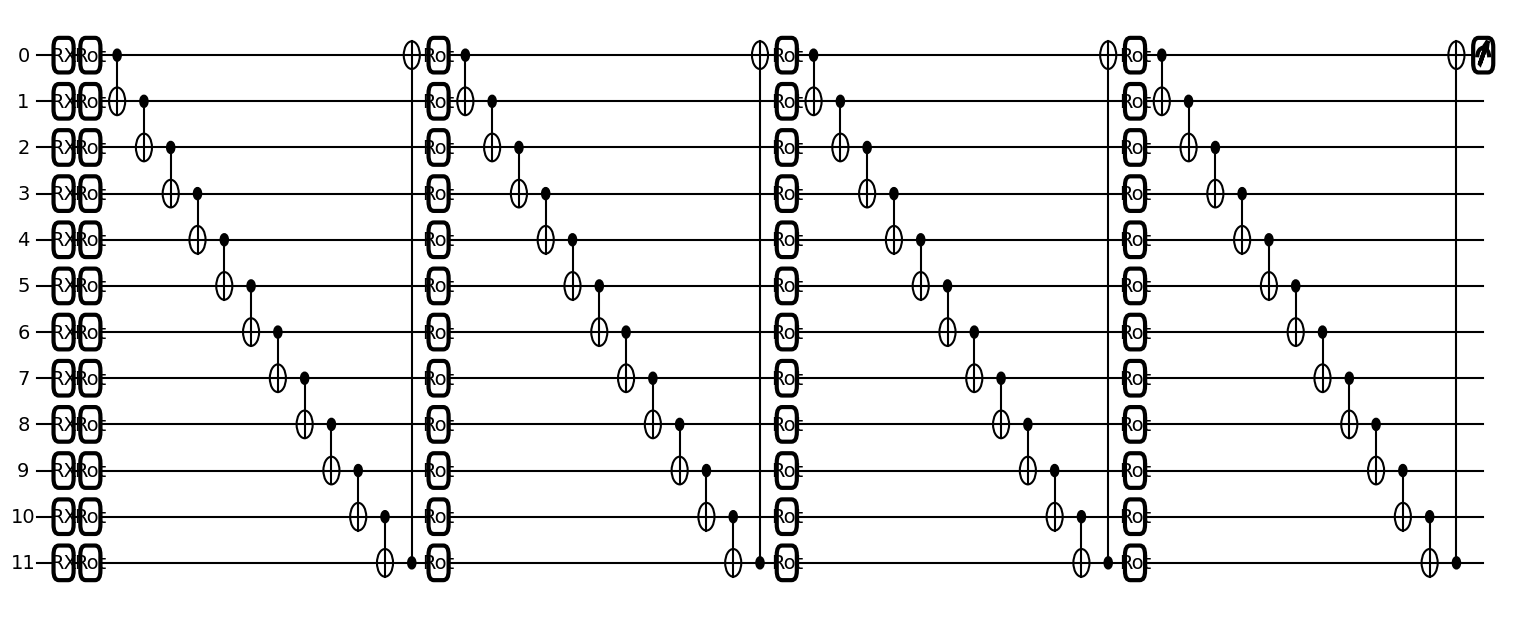

In [188]:
S.draw_circuit(size=(15, 6))

In [189]:
S.set_data(    
    data_X = data[0], 
    data_Y = data[1], 
    # data_validation = data_validation
)

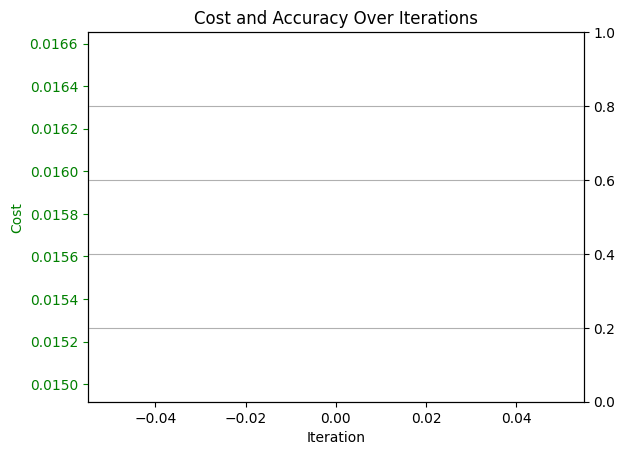

Iter:     1 | Cost: 0.0157855 | Accuracy: 0.9842145 


In [190]:
S.train(1, initialize_params=True, plot_options={
    'accuracy': False, 
    'accuracy_validation': False, 
    # 'plot_every': 1
})

In [191]:
print('Predicted score for "NCCFWCMIDHDI":', S.predict(f.string_to_angles('NCCFWCMIDHDI'))*100, ', but should be: 9.090909090909083')
print('Predicted score for "AWDAYSVVNTVE":', S.predict(f.string_to_angles('AWDAYSVVNTVE'))*100, ', but should be: -21.818181818181813')

Predicted score for "NCCFWCMIDHDI": -3.2020755913369574 , but should be: 9.090909090909083
Predicted score for "AWDAYSVVNTVE": -5.730740157840493 , but should be: -21.818181818181813


## second

In [192]:
circuit_layers2 = \
    [layers.angle_preparation()] + \
    [layers.rotationX_layer(), layers.rotationZ_layer(), layers.rotationZZ_layer()] * 15 +  \
    [layers.mesurament(qubits=[0])]

In [193]:
import pennylane as qml
S2 = m.model(
    n_qubits = 12, 
    circuit_layers = circuit_layers2, 
    batch_size = 10,
    optimizer = qml.SPSAOptimizer(maxiter=1000, c=0.15, a=0.2)
)

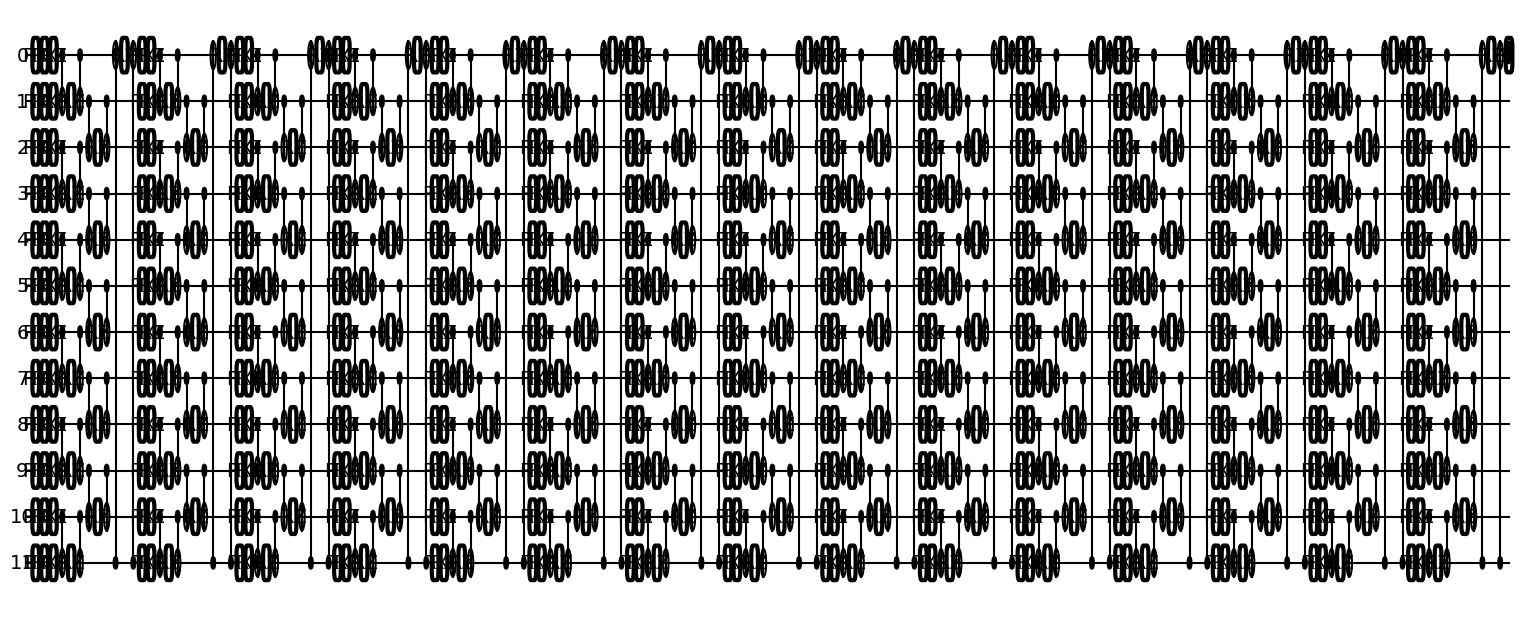

In [194]:
S2.draw_circuit(size=(15, 6))

In [195]:
S2.set_data(
    data_X = data[0], 
    data_Y = data[1], 
    # data_validation = data_validation
)

In [196]:
S2.params

[tensor([[-1.24231523],
         [-0.41910215],
         [-0.25300317],
         [-2.90151837],
         [-0.92275989],
         [-1.07195756],
         [ 0.33017524],
         [ 0.19320616],
         [-0.49682525],
         [ 1.4388948 ],
         [ 0.29104993],
         [ 0.86657043]], requires_grad=True),
 tensor([[ 1.18296555e+00],
         [ 3.45220236e-01],
         [-1.10700182e+00],
         [-1.02935981e+00],
         [ 1.08932647e+00],
         [-1.10791363e+00],
         [-1.46484891e+00],
         [ 1.03758643e+00],
         [-1.08951256e+00],
         [ 5.84937404e-04],
         [ 1.48710779e+00],
         [ 3.22235275e-01]], requires_grad=True),
 tensor([[-0.94163503],
         [ 0.04584888],
         [-1.18517698],
         [-0.21750542],
         [-0.45525947],
         [-0.64862635],
         [-0.56329863],
         [-2.71842035],
         [ 0.96962729],
         [-0.68384866],
         [-0.53209215],
         [-1.38138643]], requires_grad=True),
 tensor([[-0.77593177]

In [197]:
S2.circuit_layers

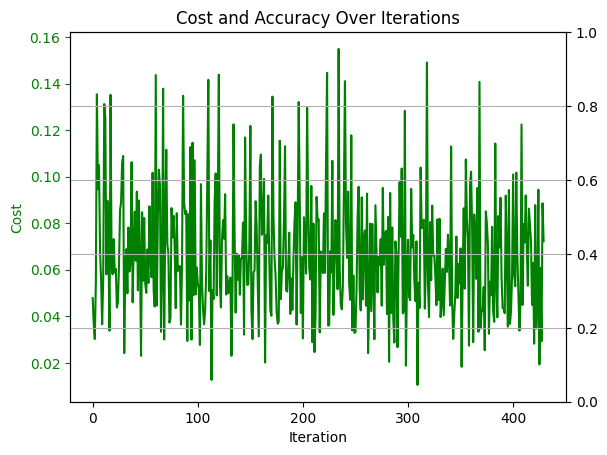

Iter:   430 | Cost: 0.0722753 | Accuracy: 0.9277247 
Iter:   431 | Cost: 0.0885871 | Accuracy: 0.9114129 


KeyboardInterrupt: 

In [198]:
S2.train(1000, initialize_params=True, plot_options={'accuracy': False, 'accuracy_validation': False, 'plot_every': 5})

In [199]:
print('Predicted score for "NCCFWCMIDHDI":', S.predict(f.string_to_angles('NCCFWCMIDHDI'))*100, ', but should be: 9.090909090909083')
print('Predicted score for "AWDAYSVVNTVE":', S.predict(f.string_to_angles('AWDAYSVVNTVE'))*100, ', but should be: -21.818181818181813')

Predicted score for "NCCFWCMIDHDI": -3.2020755913369574 , but should be: 9.090909090909083
Predicted score for "AWDAYSVVNTVE": -5.730740157840493 , but should be: -21.818181818181813
